## 프로젝트
- U-Net++ 모델을 구현
- 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었는지 시각화
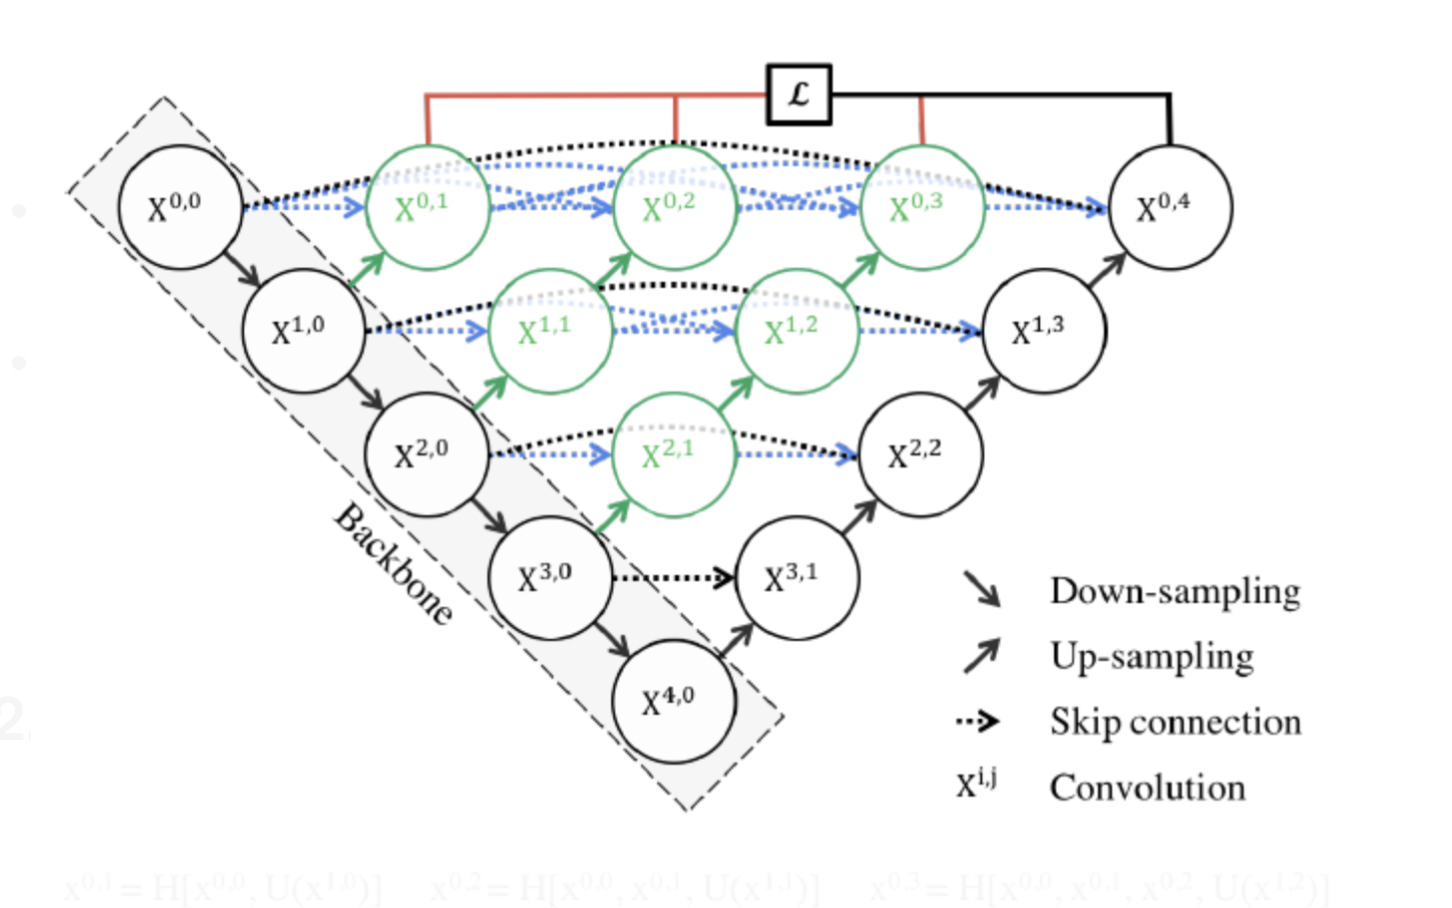

Step 1. KITTI 데이터셋 수집과 구축  
Step 2. U-Net++ 모델의 구현  
Step 3. U-Net과 U-Net++ 모델이 수행한 세그멘테이션  

## Step 1. KITTI 데이터셋 수집과 구축

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

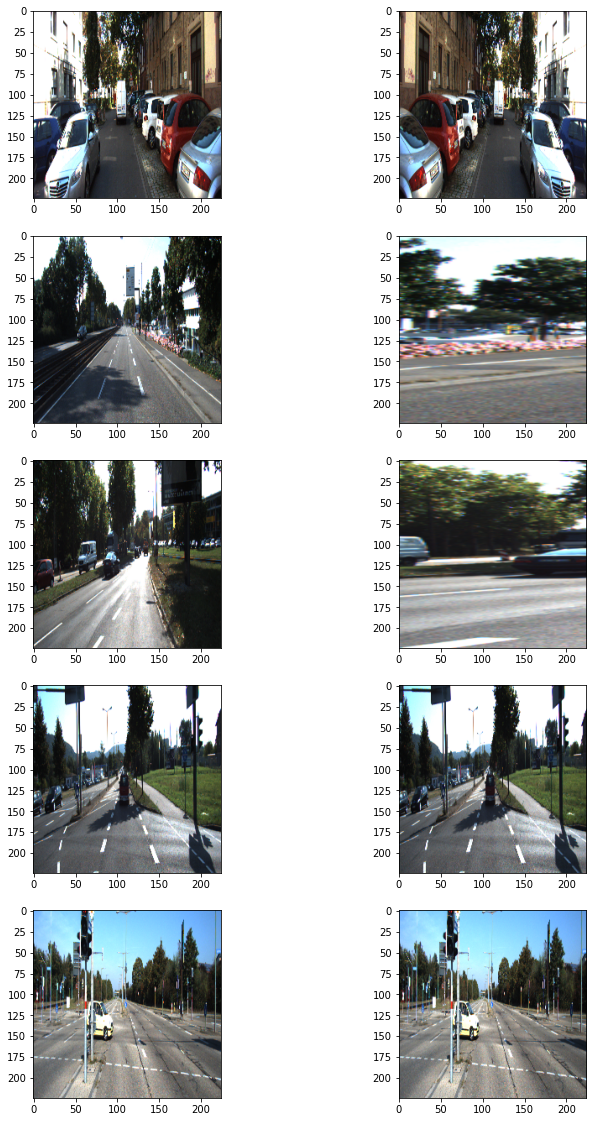

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

### tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net++ 모델의 구현

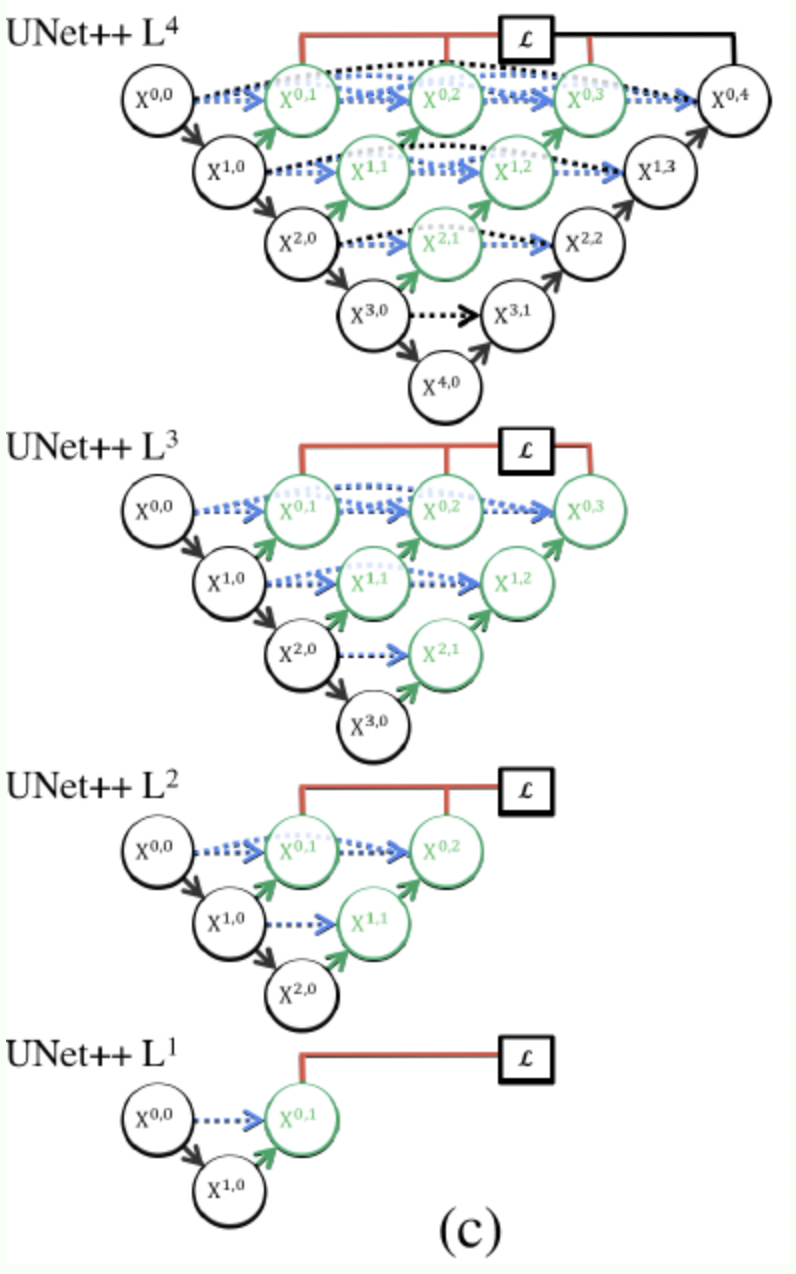
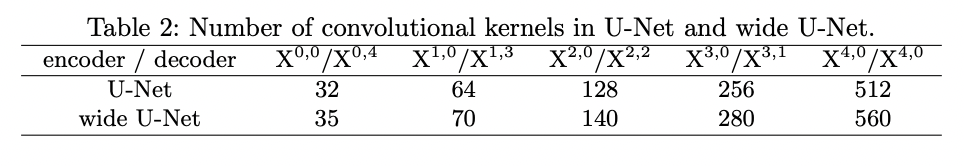

UNet++L1 -> UNet++L2 -> UNet++L3 -> UNet++L4 순서로 쌓으면 된다.  
그림때문에 헷갈렸는데, 밑에서부터 위로 점점 쌓으면 된다. 

In [6]:
def build_model(input_shape=(224, 224, 3), deep_supervision=False):
    inputs = Input(input_shape)
	
#L1
    x0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    x0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_0)
    x1_0 = MaxPooling2D(pool_size=(2, 2))(x0_0)    
    x1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x1_0)
    x1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x1_0)
    up1_0 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x1_0)
    x0_1 = concatenate([x0_0,up1_0], axis = 3)
    x0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_1)
    x0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_1)
    
# --------------------------------------------- #    
# L2    
    x2_0 = MaxPooling2D(pool_size=(2, 2))(x1_0)
    x2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x2_0)
    x2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x2_0)
    up2_0 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x2_0)
    x1_1 = concatenate([x1_0,up2_0], axis = 3)
    x1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x1_1)
    x1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x1_1)
    up1_1 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x1_1)
    x0_2 = concatenate([x0_0, x0_1, up1_1])
    x0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_2)
    x0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_2)

# --------------------------------------------- #    
# L3 
    x3_0 = MaxPooling2D(pool_size=(2, 2))(x2_0)
    x3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x3_0)
    x3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x3_0)
    up3_0 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x3_0)
    x2_1 = concatenate([x2_0,up3_0], axis = 3)
    x2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x2_1)
    x2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x2_1)
    up2_1 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x2_1)  
    x1_2 = concatenate([x1_0, x1_1, up2_1])
    x1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x1_2)
    x1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x1_2)
    up1_2 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x1_2)
    x0_3 = concatenate([x0_0, x0_1, x0_2, up1_2])
    x0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_3)
    x0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_3)
    
# --------------------------------------------- #    
# L4
    x4_0 = MaxPooling2D(pool_size=(2, 2))(x3_0)
    x4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x4_0)
    x4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x4_0)
    up4_0 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x4_0)
    x3_1 = concatenate([x3_0, up4_0], axis = 3)
    x3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x3_1)
    x3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x3_1)
    up3_1 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x3_1)
    x2_2 = concatenate([x2_0, x2_1, up3_1], axis = 3)
    x2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x2_2)
    x2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x2_2)
    up2_2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x2_2)  
    x1_3 = concatenate([x1_0, x1_1, x1_2, up2_2])
    x1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x1_3)
    x1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x1_3)
    up1_3 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x1_3)
    x0_4 = concatenate([x0_0, x0_1, x0_2, x0_3, up1_3])
    x0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_4)
    x0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_4)

    output_1 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same')(x0_1)
    output_2 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same')(x0_2)
    output_3 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same')(x0_3)
    output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same')(x0_4)
    
    if deep_supervision:
        model = Model(inputs = inputs, outputs = [output_1,
                                                  output_2,
                                                  output_3,
                                                  output_4])
    else:
        model = Model(inputs = inputs, outputs =[output_4])

    return  model

In [7]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetplus.h5'

model = build_model()

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 118s 2s/step - loss: 0.5750 - val_loss: 0.1147
Epoch 2/100
43/43 [==============================] - 66s 2s/step - loss: 0.1142 - val_loss: 0.1414
Epoch 3/100
43/43 [==============================] - 66s 2s/step - loss: 0.1255 - val_loss: 0.1527
Epoch 4/100
43/43 [==============================] - 67s 2s/step - loss: 0.1297 - val_loss: 0.1173
Epoch 5/100
43/43 [==============================] - 66s 2s/step - loss: 0.1056 - val_loss: 0.1440
Epoch 6/100
43/43 [==============================] - 66s 2s/step - loss: 0.1224 - val_loss: 0.1030
Epoch 7/100
43/43 [==============================] - 66s 2s/step - loss: 0.1053 - val_loss: 0.1154
Epoch 8/100
43/43 [==============================] - 67s 2s/step - loss: 0.1055 - val_loss: 0.1098
Epoch 9/100
43/43 [==============================] - 66s 2s/step - loss: 0.0981 - val_loss: 0.1053
Epoch 10/100
43/43 [==============================] - 66s 2s/step - loss: 0.0971 - val_loss: 0.1020
Epoch 11

43/43 [==============================] - 65s 2s/step - loss: 0.0311 - val_loss: 0.0500
Epoch 84/100
43/43 [==============================] - 66s 2s/step - loss: 0.0311 - val_loss: 0.0510
Epoch 85/100
43/43 [==============================] - 66s 2s/step - loss: 0.0287 - val_loss: 0.0553
Epoch 86/100
43/43 [==============================] - 65s 2s/step - loss: 0.0357 - val_loss: 0.0569
Epoch 87/100
43/43 [==============================] - 65s 2s/step - loss: 0.0381 - val_loss: 0.0635
Epoch 88/100
43/43 [==============================] - 65s 2s/step - loss: 0.0293 - val_loss: 0.0677
Epoch 89/100
43/43 [==============================] - 66s 2s/step - loss: 0.0309 - val_loss: 0.0537
Epoch 90/100
43/43 [==============================] - 66s 2s/step - loss: 0.0341 - val_loss: 0.0357
Epoch 91/100
43/43 [==============================] - 66s 2s/step - loss: 0.0337 - val_loss: 0.0528
Epoch 92/100
43/43 [==============================] - 65s 2s/step - loss: 0.0254 - val_loss: 0.0374
Epoch 93/100


## Step 3. U-Net과 U-Net++ 모델이 수행한 세그멘테이션  

In [20]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

In [21]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = tf.keras.models.load_model(model_path)

### U-Net 도로 검출 세그맨테이션 시각화

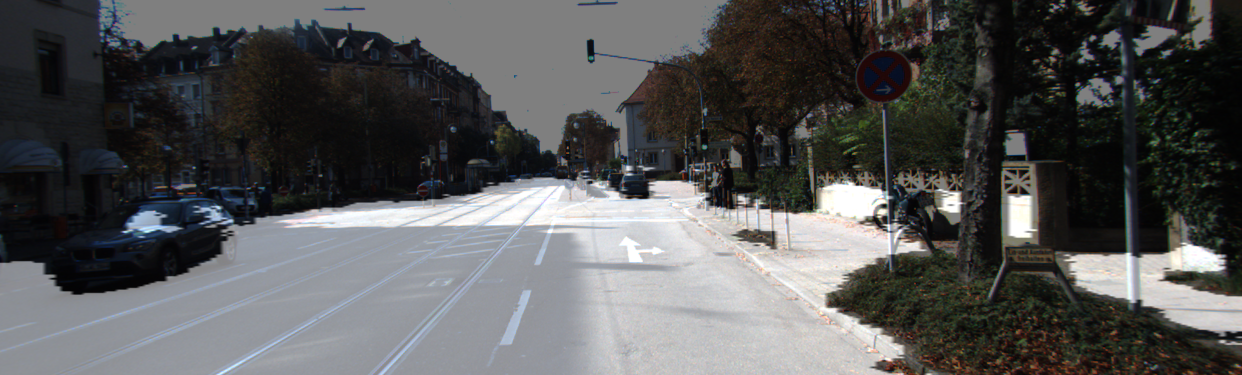

In [22]:
# 시각화 결과 확인
i = 1    
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [23]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetplus.h5'

model = tf.keras.models.load_model(model_path)

### U-Net++ 도로 검출 세그맨테이션 시각화

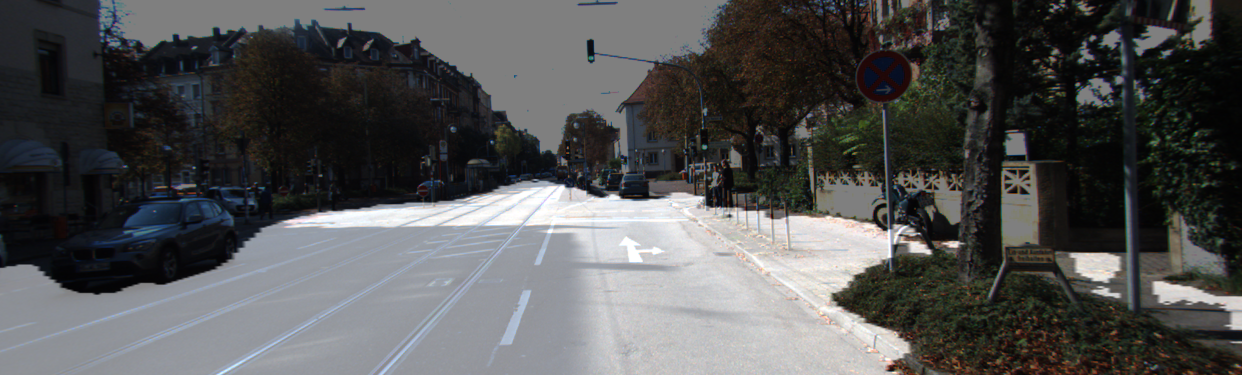

In [24]:
# 시각화 결과 확인
i = 1    
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [25]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('Iou : %f' % iou_score )
    return iou_score

In [14]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [15]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

### U-Net++가 수행한 세그맨테이션 IoU 결과

In [16]:
calculate_iou_score(target, prediction)

Iou : 0.847569


0.8475692558392178

In [17]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = tf.keras.models.load_model(model_path)

In [18]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

### U-Net가 수행한 세그맨테이션 IoU 결과

In [19]:
calculate_iou_score(target, prediction)

Iou : 0.784681


0.7846806387225549

## 회고
- 처음에 U-Net 구현을 어떻게 해야 하는지 몰라서 깃허브 파이토치 코드를 참고했다.(링크:https://github.com/4uiiurz1/pytorch-nested-unet/blob/master/archs.py)
- 결과를 봤을 때, U-Net모델이 수행한 세그맨테이션의 IoU의 결과가 **0.78**이고, U-Net++모델이 수행한 세그맨테이션의 IoU의 결과가 **0.84**인 것으로 보아 U-Net++의 성능이 더 좋다. 
- 시각화한 사진을 비교해도 U-Net++가 도로를 더 잘 검출하고 있음을 볼 수 있다. 오른쪽의 인도쪽을 보면 U-Net은 울타리도 도로로 인식하는 반면, U-Net++는 그렇지 않다.
- 논문에서는 deep_supervision 중 첫번째 모드가 4개의 결과를 모두 더한 다음에 평균을 내는 것으로 나타나 있는 것 같은데(원문: accurate mode wherein the outputs from all segmentation branches are average) 일단은 참고한 코드에서는 두번째 모드를 사용하는 것 같아서 무시했다.

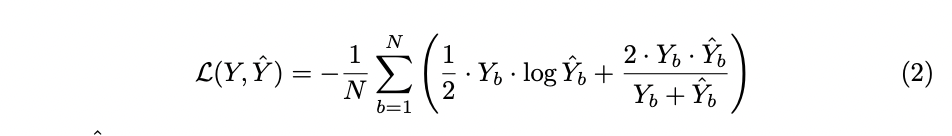
- 로스 함수로 위의 식을 사용했다고 하는데, 잘 몰라서 `binary_crossentropy`만 사용했다. 논문에서는 `dice coefficient`를 합쳤다고 한다.
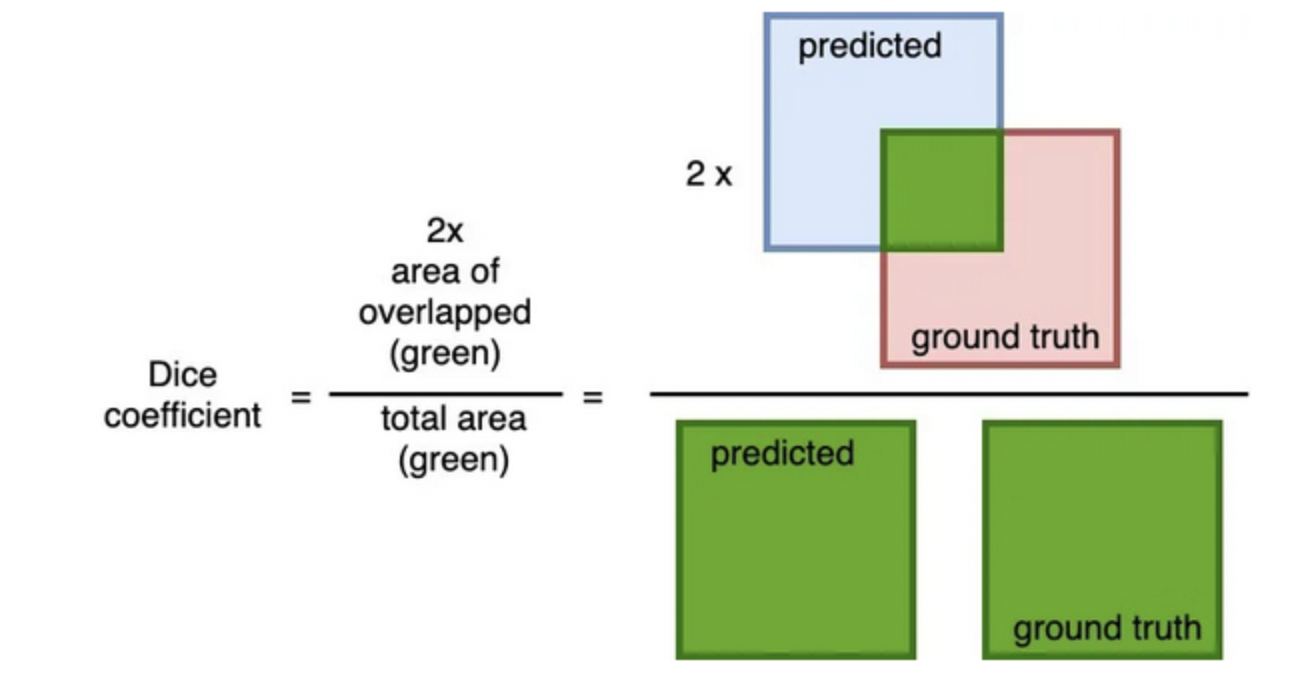